In [63]:
import os # import OS package
import numpy as np # import numpy package
import pandas as pd # import package
import matplotlib.pyplot as pl # import matplotlib.pyplot

from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor as NN
from sklearn.metrics import mean_absolute_error, make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

import pylab as pl
from mpl_toolkits.mplot3d import Axes3D

print("Done :)")

Done :)


In [38]:
hp = pd.read_csv('hpdemo.csv',dtype=float) # import dataset


In [44]:
current_dir = os.getcwd( )
my_dir = 'c:\\Users\\PAUL\\Documents\\A_Maynooth HDip\\NCG603A (NCG613) - Geocomputation\\Python project'
if current_dir != my_dir:
        print("Setting up working directory...")
        os.chdir(my_dir)        
print("Current working directory is: ", os.getcwd( ))


Current working directory is:  c:\Users\PAUL\Documents\A_Maynooth HDip\NCG603A (NCG613) - Geocomputation\Python project


In [45]:
print(hp.head(5)) # quick look at dataset portion (first 10 rows)

    ID      east     north     price  fl_area
0  1.0  523800.0  179700.0  107000.0     50.0
1  2.0  533200.0  170900.0   55500.0     66.0
2  3.0  514600.0  175800.0  103000.0     90.0
3  4.0  516000.0  171000.0  187000.0    125.0
4  5.0  533700.0  169200.0   43000.0     50.0


In [46]:
x_scaler = StandardScaler() # create scaler object
x_scaler.fit(hp[['east','north','fl_area']]) # calibrate scaler object

X = x_scaler.transform(hp[['east','north','fl_area']]) # transform to z-scores
print(X[:6,:])


[[-0.46109525 -0.0036912  -1.16501944]
 [ 0.39051366 -1.02696462 -0.73029338]
 [-1.29458482 -0.45718737 -0.07820428]
 [-1.16774945 -1.01533651  0.87275899]
 [ 0.435812   -1.22464244 -1.16501944]
 [ 1.72228503  1.1474914   0.05764762]]


In [52]:
# e.g. design an NN model with tuning params set
reg_object = NN(n_neighbors=6,weights='uniform',p=2)

price = hp['price']/1000.0 # divided by 1,000, as sometimes large values of data can lead to rounding errors
reg_object.fit(X,price) # calibrates the reg_model object

# predict the price of a house whose grid reference is 523800E 179750N and whose floor area is 55 square metres
predicted_price = reg_object.predict(x_scaler.transform([[523800.0,179750.0,55.0]]))
print(predicted_price)


[128.5]


In [53]:
# make_scorer creates the scoring object and mean_absolute_error specifies the kind of scorer to use
mae = make_scorer(mean_absolute_error, greater_is_better = False)

# DESIGN the model
# estimator specifies the machine learning algorithm that you will be using
# scoring specifies the scoring method, here it is mae
# param_grid is a dictionary. Each element has the name of one of the tuning parameters
# as the key, and a list of parameter values as the value, this specifies the values of 
# tuning parameters to search - each combination of items in the dictionary will be tested,
# and combination with the best MAE will be selected. The value is returned and stored in opt_nn
opt_nn = GridSearchCV( estimator = NN(), scoring = mae,
        param_grid = { 'n_neighbors':range(1,35), 'weights':['uniform','distance'], 'p':[1,2] } )


# calibrate the model
opt_nn.fit(X,price)

# perform the prediction
predicted_hp = opt_nn.predict(x_scaler.transform([[523800.0,179750.0,55.0]]))
print(predicted_hp)

C:\Users\PAUL\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


[121.78783506]


In [54]:
# see which tuning parameters were actually chosen in the optimal model - and what its MAE score was
print(opt_nn.best_estimator_.get_params())

{'algorithm': 'auto', 'leaf_size': 30, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': None, 'n_neighbors': 13, 'p': 1, 'weights': 'distance'}


In [55]:
# attribute best_score_ returns the actual score
print(opt_nn.best_score_)

-26.487173782084888


In [56]:
# write a function to extract info from reg_object
def print_summary(opt_reg_object):
    params = opt_reg_object.best_estimator_.get_params()
    score = - opt_reg_object.best_score_
    print("Nearest neighbours: %8d" % params['n_neighbors'])
    print("Minkowski p       : %8d" % params['p'])
    print("Weighting         : %8s" % params['weights'])
    print("MAE Score         : %8.2f" % score)
    return

# call function
print_summary(opt_nn)


Nearest neighbours:       13
Minkowski p       :        1
Weighting         : distance
MAE Score         :    26.49


# pipelines

In [59]:
# design a pipeline object to perform scaling, transform and ML regression
pipe = Pipeline([('zscores',StandardScaler()),
    ('NNreg',NN(n_neighbors=6,weights='uniform',p=2))])

# calibrate the model
pipe.fit(hp[['east','north','fl_area']],price)

# repeat the prediction step, but this time using unscaled data
predicted_hp2 = pipe.predict([[523800.0,179750.0,55.0]])
print(predicted_hp2)

[128.5]


In [60]:
# use pipelines with `GridSearchGV
pipe = Pipeline([('zscores',StandardScaler()),('NNreg',NN())])

# pipe now becomes the estimator
opt_nn2 = GridSearchCV(
    estimator = pipe,
    scoring = mae,
    param_grid = {
        'NNreg__n_neighbors':range(1,35),
        'NNreg__weights':['uniform','distance'],
        'NNreg__p':[1,2]})

# calibrate the model
opt_nn2.fit(hp[['east','north','fl_area']],price)

# repeat the prediction step, but this time using unscaled data
predicted_hp2 = opt_nn2.predict([[523800.0,179750.0,55.0]])

C:\Users\PAUL\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


In [61]:
# use the best_estimator_ and best_score_ techniques to find the tuning parameters and score
def print_summary2(opt_pipe_object):
    params = opt_pipe_object.best_estimator_.get_params()
    score = - opt_pipe_object.best_score_
    print("Nearest neighbours: %8d" % params['NNreg__n_neighbors'])
    print("Minkowski p       : %8d" % params['NNreg__p'])
    print("Weighting         : %8s" % params['NNreg__weights'])
    print("MAE Score         : %8.2f" % score)
    return

# call function
print_summary2(opt_nn2)


Nearest neighbours:       13
Minkowski p       :        1
Weighting         : distance
MAE Score         :    26.47


# visualising

In [62]:
# To cover the area in the data, eastings should range from 505000 to 555800, and northings from 158400 to 199900.
# To create a grid of 100 by 100 points
east_mesh, north_mesh = np.meshgrid(np.linspace(505000,555800,100), np.linspace(158400,199900,100))

# creates a new array of the same shape as 'east_mesh' but containing only zeros
fl_mesh = np.zeros_like(east_mesh)

# assign every element of this array with the average floor size
fl_mesh[:,:] = np.mean(hp['fl_area'])

# verify prediction variables are all available in the form of 2D arrays
print(east_mesh.shape)
print(north_mesh.shape)


(100, 100)
(100, 100)


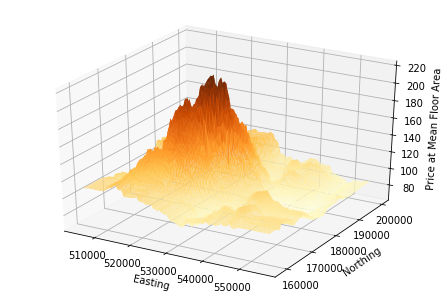

In [64]:
# unravel all three variables and put them into the format that the predict method expects
grid_predictor_vars = np.array([east_mesh.ravel(), north_mesh.ravel(),fl_mesh.ravel()]).T 

# these can be used in the predict method
hp_predictions = opt_nn2.predict(grid_predictor_vars)

# reshape hp_predictions - make it same as eash_mesh (100x100)
hp_mesh = hp_predictions.reshape(east_mesh.shape)

fig = pl.figure()
ax = Axes3D(fig)
ax.plot_surface(east_mesh, north_mesh, hp_mesh, rstride=1, cstride=1, cmap='YlOrBr',lw=0.01)
ax.set_xlabel('Easting')
ax.set_ylabel('Northing')
ax.set_zlabel('Price at Mean Floor Area')
pl.show()

# put it all into a single function

In [68]:
def surf3d(pipe_model,fl_area):
    
    east_mesh, north_mesh = np.meshgrid(np.linspace(505000,555800,100), np.linspace(158400,199900,100))
    fl_mesh = np.zeros_like(east_mesh)
    fl_mesh[:,:] = fl_area
    
    grid_predictor_vars = np.array([east_mesh.ravel(), north_mesh.ravel(),fl_mesh.ravel()]).T
    hp_pred = pipe_model.predict(grid_predictor_vars)
    hp_mesh = hp_pred.reshape(east_mesh.shape)
    
    fig = pl.figure()
    ax = Axes3D(fig)
    ax.plot_surface(east_mesh, north_mesh, hp_mesh, 
        rstride=1, cstride=1, cmap='YlOrBr',lw=0.01)
    ax.set_xlabel('Easting')
    ax.set_ylabel('Northing')
    ax.set_zlabel('Price at Mean Floor Area')
    pl.show()
    return


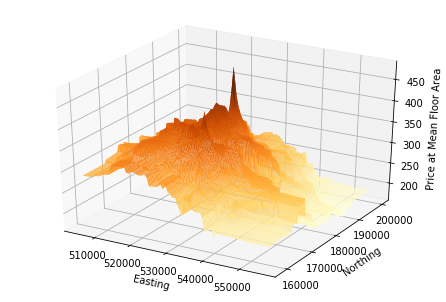

In [73]:
# create figures with alternative floor area values: for example, for 150 square meters
pl.close()
surf3d(opt_nn2,200.0)
pl.show()